In [1]:
from typing import Dict

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST 
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import brevitas.nn as qnn


In [2]:
project_path = Path.cwd().parents[1]
mnist_path = project_path/'data/mnist'
mnist_path

PosixPath('/home/dk/Desktop/projects/PocketHHE/data/mnist')

In [3]:
weight_bit_width = 4
save_weight_path = project_path/f"quant_he_code/weights/quant_hcnn_4bits_mnist_plain_{weight_bit_width}bits.pth"

## Prepare the dataset and dataloader for training

Quantize into [0, 0.25, 0.5, 0.75, 1]

In [6]:
train_dataset = MNIST(
    root=mnist_path, 
    download=False, 
    transform=transforms.Compose([
        ToTensor(),
        lambda x: (x*4).int(),
        lambda x: x.float()/4,
]))
test_dataset = MNIST(
    root=mnist_path, 
    train=False, 
    transform=transforms.Compose([
        ToTensor(),
        lambda x: (x*4).int(),
        lambda x: x.float()/4,
]))

Quantize into [0, 1, 2, 3]

In [23]:
train_dataset = MNIST(
    root=mnist_path, 
    download=False, 
    transform=transforms.Compose([
        ToTensor(),
        lambda x: (x * 3).int().float()
]))
test_dataset = MNIST(
    root=mnist_path, 
    train=False, 
    transform=transforms.Compose([
        ToTensor(),
        lambda x: (x * 3).int().float()
]))

Inspecting the data

torch.Size([28, 28])
Processed MNIST data unique values = tensor([0., 1., 2., 3.])


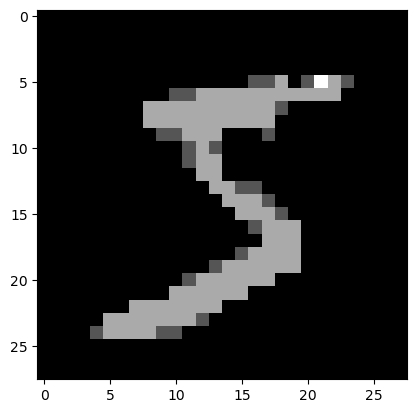

In [24]:
im = train_dataset[0][0][0]
print(im.shape)
print(f"Processed MNIST data unique values = {im.unique()}")
plt.imshow(im, cmap='gray')

Preparing training and validation data for training

In [25]:
torch.manual_seed(43)
val_size = 5000
train_size = len(train_dataset) - val_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
batch_size = 32

train_loader = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size * 2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size * 2, pin_memory=True)


Get if device is GPU or CPU. Bring data onto the device

In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, data_loader, device):
        self.dl = data_loader
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

Inspecting the data loader

In [27]:
for x, y in train_loader:
    print(x.shape, y.shape)
    print(x.unique())
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])
tensor([0., 1., 2., 3.], device='cuda:0')


## Prepare the CNN model (2 conv layers + 1 linear layer)

In [28]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    """
    PytorchLightining style
    """
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch) -> Dict:
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs) -> Dict:
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result) -> None:
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch + 1, result['val_loss'], result['val_acc']))

Define the QAT Conv Model

In [29]:
class MNISTConvQuantModel(ImageClassificationBase):
    """
    2 conv layers + 2 square activations + 1 linear layer
    """
    def __init__(self):
        super().__init__()
        self.conv1 = qnn.QuantConv2d(in_channels=1, out_channels=5, kernel_size=5, 
                                     stride=(2, 2), padding=0, bias=False, 
                                     weight_bit_width=weight_bit_width, 
                                     return_quant_tensor=True)
        self.conv2 = qnn.QuantConv2d(in_channels=5, out_channels=50, kernel_size=5, 
                                     stride=(2, 2), padding=0, bias=False, 
                                     weight_bit_width=weight_bit_width)
        self.fc1 = qnn.QuantLinear(in_features=800, out_features=10, bias=False, 
                                   weight_bit_width=weight_bit_width, 
                                   return_quant_tensor=True)

    def forward(self, xb):
        out = self.conv1(xb)
        out = out * out  # first square
        out = self.conv2(out)
        out = out.reshape(out.shape[0], -1)
        out = out * out  # second square
        out = self.fc1(out)

        return out

Define the QAT 2-FC Model

In [ ]:
class MNISTLinearQuantModel(ImageClassificationBase):
    """
    2 linear layers + 2 square activations
    """
    def __init__(self):
        super().__init__()
        self.fc1 = qnn.QuantLinear(in_features=28*28, out_features=128, bias=False, 
                                   weight_bit_width=weight_bit_width,
                                   return_quant_tensor=True)
        
        self.fc2 = qnn.QuantLinear(in_features=128, out_features=10, bias=False, 
                                   weight_bit_width=weight_bit_width, 
                                   return_quant_tensor=True)

    def forward(self, xb):
        out = self.fc1(xb)
        out = out * out  # first square
        # out = out.reshape(out.shape[0], -1)
        out = self.fc2(out)

        return out

In [30]:
model = to_device(MNISTConvQuantModel(), device)
model

MNISTConvQuantModel(
  (conv1): QuantConv2d(
    1, 5, kernel_size=(5, 5), stride=(2, 2), bias=False
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_im

## Train and evaluate

In [31]:
def evaluate(model, val_loader) -> Dict:
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, 
        train_loader, val_loader, test_loader, 
        file_name, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    high_acc = 0.98
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

        if epoch >= 2:
            eval_dict = evaluate(model, test_loader)
            print(str(epoch) + "\t" + str(eval_dict))
            if eval_dict['val_acc'] > high_acc:
                high_acc = eval_dict['val_acc']
                torch.save(model.state_dict(), file_name)
                print("Saved")

    return history


In [32]:
history = [evaluate(model, val_loader)]
history += fit(epochs=150, lr=0.001, model=model, 
               train_loader=train_loader, 
               val_loader=val_loader, 
               test_loader=test_loader, 
               file_name=save_weight_path, 
               opt_func=torch.optim.Adam)


/tmp/ipykernel_108533/3874017255.py:2: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:363.)
  _, preds = torch.max(outputs, dim=1)


Epoch [1], val_loss: 0.1562, val_acc: 0.9585
Epoch [2], val_loss: 0.1007, val_acc: 0.9717
Epoch [3], val_loss: 0.0980, val_acc: 0.9719
2	{'val_loss': 0.09899615496397018, 'val_acc': 0.9766122698783875}
Epoch [4], val_loss: 0.0801, val_acc: 0.9777
3	{'val_loss': 0.07495930045843124, 'val_acc': 0.9809912443161011}
Saved
Epoch [5], val_loss: 0.0799, val_acc: 0.9784
4	{'val_loss': 0.07751865684986115, 'val_acc': 0.9795979261398315}
Epoch [6], val_loss: 0.0828, val_acc: 0.9788
5	{'val_loss': 0.07836957275867462, 'val_acc': 0.9811902642250061}
Saved
Epoch [7], val_loss: 0.1264, val_acc: 0.9689
6	{'val_loss': 0.13192443549633026, 'val_acc': 0.9696456789970398}


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Final evaluation on the test dataset

In [ ]:
print(evaluate(model, test_loader))


/tmp/ipykernel_93415/3874017255.py:2: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:363.)
  _, preds = torch.max(outputs, dim=1)


{'val_loss': 0.2583501935005188, 'val_acc': 0.9856687784194946}
